# Vehicle Detection

### William Rifenburgh

---

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

---


In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import time
import glob
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from LaneDetection import *

%matplotlib inline

### Histogram of Oriented Gradients

The following two cells define a color conversion function that we use to transform the color of classification trainging images and the HOG image feature vector function.


In [2]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    # Define a function to return HOG features and visualization   
    
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient,
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  transform_sqrt=True,
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:
        features = hog(img, orientations=orient,
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       transform_sqrt=True,
                       visualise=vis, feature_vector=feature_vec)
        return features

The following cell loads the training image data and displays the output of the HOG image for each channel of some sample images. The HOG images for some images in YCrCb colorspace are shown below. This colorspace is optimal because it allows creation of HOG feature vectors that are more descriptive than RGB colorspace. This is because the channels in RGB colorspace are redundant in the information each channel presents.

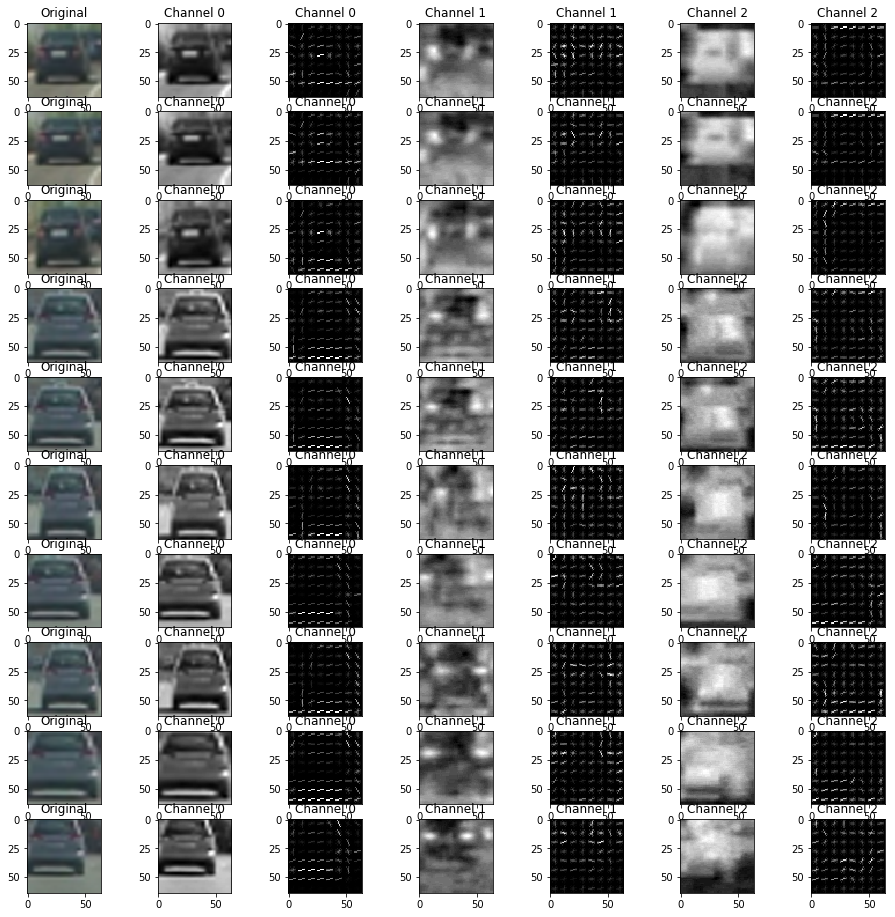

In [25]:
# Read in cars and notcars
cars = glob.glob('./vehicles/*/*.png')
notcars = glob.glob('./non-vehicles/*/*.png')

# Use the same amount of cars samples as notcar samples
sample_size = min(len(cars), len(notcars))
cars = cars[0:sample_size]
notcars = notcars[0:sample_size]

cars_subsample = cars[0:10]

orient = 9  # HOG orientations
pix_per_cell = 8  # HOG pixels per cell
cell_per_block = 4  # HOG cells per block

fig = plt.figure(figsize=(16, 16))
plts_per_row = 7

for idx, file in enumerate(cars_subsample):
    original = mpimg.imread(file)
    image = convert_color(original, conv='RGB2YCrCb')
    fig.add_subplot(len(cars_subsample), plts_per_row, plts_per_row * idx + 1)
    plt.imshow(original)
    plt.title('Original')
    for channel in range(image.shape[2]):
        features, hog_image = get_hog_features(image[:, :, channel], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
        
        # Plot Channel
        fig.add_subplot(len(cars_subsample), plts_per_row, plts_per_row * idx + 2*channel + 2)
        plt.imshow(image[:, :, channel], cmap='gray')
        plt.title('Channel ' + str(channel))
        
        # Plot HOG image of channel
        fig.add_subplot(len(cars_subsample), plts_per_row, plts_per_row * idx + 2*channel + 3)
        plt.imshow(hog_image, cmap='gray')
        plt.title('Channel ' + str(channel))

## Color Features

The following cells define the functions to create featue vectors based on spatial binning and color histograms of a window image

In [4]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel()
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:, :, 0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:, :, 1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:, :, 2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                     hist_bins=32, orient=9,
                     pix_per_cell=8, cell_per_block=2, hog_channel=0,
                     spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else:
            feature_image = np.copy(image)

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
            # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:, :, channel],
                                                         orient, pix_per_cell, cell_per_block,
                                                         vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)
            else:
                hog_features = get_hog_features(feature_image[:, :, hog_channel], orient,
                                                pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

## Training the Classifier

The following cell trains the support vector classifier used to classify the window samples taken from a frame and saves the classifier to pickle file.
The classifier was trained using images taken from the GTI and KITTI databases as well as the video itself.

9 orientation bins and 8 pixels per cell were chosen for the HOG feature generator as they seemed sufficient in the lesson examples. Block normalization was not used (cells per block = 1) as it seemed only to multiply the size of the HOG feature vector, greatly increase computation time and only minimally improve accuracy.

In [32]:
color_space = 'YCrCb'  # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8  # HOG pixels per cell
cell_per_block = 1  # HOG cells per block
hog_channel = "ALL"  # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16)  # Spatial binning dimensions
hist_bins = 32  # Number of histogram bins
spatial_feat = True  # Spatial features on or off
hist_feat = True  # Histogram features on or off
hog_feat = True  # HOG features on or off
y_start_stop = [400, 656]  # Min and max in y to search in slide_window()

car_features = extract_features(cars, color_space=color_space,
                                spatial_size=spatial_size, hist_bins=hist_bins,
                                orient=orient, pix_per_cell=pix_per_cell,
                                cell_per_block=cell_per_block,
                                hog_channel=hog_channel, spatial_feat=spatial_feat,
                                hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space,
                                   spatial_size=spatial_size, hist_bins=hist_bins,
                                   orient=orient, pix_per_cell=pix_per_cell,
                                   cell_per_block=cell_per_block,
                                   hog_channel=hog_channel, spatial_feat=spatial_feat,
                                   hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:', orient, 'orientations', pix_per_cell,
      'pixels per cell and', cell_per_block, 'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t = time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2 - t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t = time.time()

#save params and trained svc to pickle
dist_pickle = {'svc': svc, 'scaler': X_scaler, 'orient': orient, 'pix_per_cell': pix_per_cell,
               'cell_per_block': cell_per_block, 'spatial_size': spatial_size, 'hist_bins': hist_bins}

pickle.dump( dist_pickle, open( "svc_pickle.p", "wb" ) )

Using: 9 orientations 8 pixels per cell and 1 cells per block
Feature vector length: 2592
5.85 Seconds to train SVC...
Test Accuracy of SVC =  0.9844


In [5]:
# Use this cell to load the pickle so we don't have to train the classifier everytime we open this jupyter notebook
dist_pickle = pickle.load(open("svc_pickle.p", "rb"))
svc = dist_pickle["svc"]
X_scaler = dist_pickle["scaler"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatial_size = dist_pickle["spatial_size"]
hist_bins = dist_pickle["hist_bins"]

## Sliding Window Search
The find_cars function below takes identifies the HOG features of the bottom half of a video frame once. It then proceeds to extract window color features across the lower region by using spatial binning and color histograms for each window, combining the color feature vectors with the HOG feautres, and then classifying each window with the previously trained support vector classifier.

The sliding window search implemented slid down and across the scanning area by 2 cells in each direction to process windows of 64 pixels in height and width, the same size as the training data samples.

In [31]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):

    draw_img = np.copy(img)
    img = img.astype(np.float32) / 255
    bboxes = []

    img_tosearch = img[ystart:ystop, :, :]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1] / scale), np.int(imshape[0] / scale)))

    ch1 = ctrans_tosearch[:, :, 0]
    ch2 = ctrans_tosearch[:, :, 1]
    ch3 = ctrans_tosearch[:, :, 2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1
    nfeat_per_block = orient * cell_per_block ** 2

    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step

    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb * cells_per_step
            xpos = xb * cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos * pix_per_cell
            ytop = ypos * pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop + window, xleft:xleft + window], (64, 64))

            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(
                np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)


            if test_prediction == 1:
                xbox_left = np.int(xleft * scale)
                ytop_draw = np.int(ytop * scale)
                win_draw = np.int(window * scale)
                box = ((xbox_left, ytop_draw + ystart), (xbox_left + win_draw, ytop_draw + win_draw + ystart))
                bboxes.append(box)
                cv2.rectangle(draw_img, (xbox_left, ytop_draw + ystart),
                              (xbox_left + win_draw, ytop_draw + win_draw + ystart), (0, 0, 255), 6)

    return draw_img, bboxes

## Heat maps
To eliminate false positives and group duplicate detections, the following functions create a heat map by adding 1 to the pixels within a bounding box of a positive detection and then tresholding a heat map by a given value to eliminate false positives. All pixels with values that met the threshold may be grouped together using the label function from scipy.ndimage.measurements to merge duplication detections into one detection.

The draw_labled_bboxes function takes the output of the label function and draws the final bounding boxes on what will be identified as vehicles

In [15]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0, 0, 255), 6)
        cv2.putText(img, 'CAR ' + str(car_number), bbox[0], cv2.FONT_HERSHEY_PLAIN, 2, (255, 255, 255), 3)
    # Return the image
    return img

The following cell plots the original test image, a heatmap, and a final detection image for all images in the 'test_images' folder. Using these results as feedback allowed for the tuning of the classifier parameters increase reliabilty and speed.

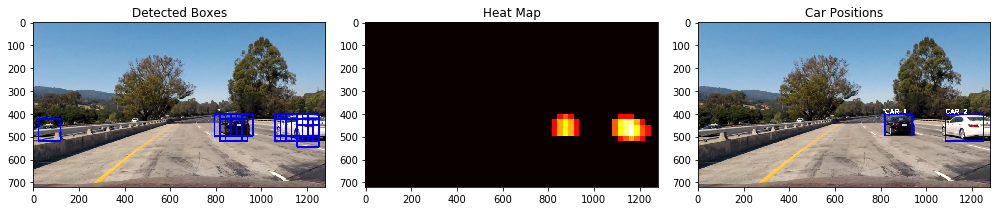

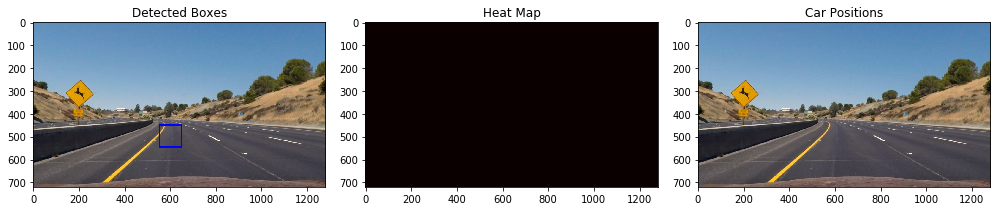

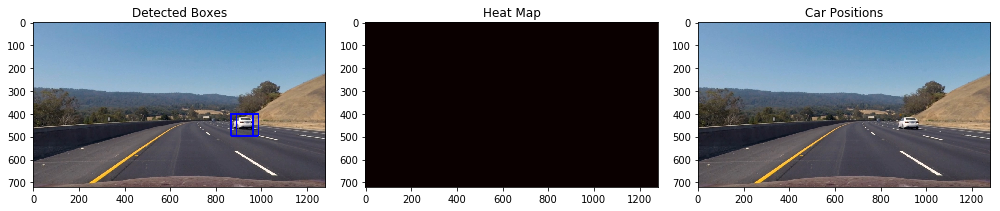

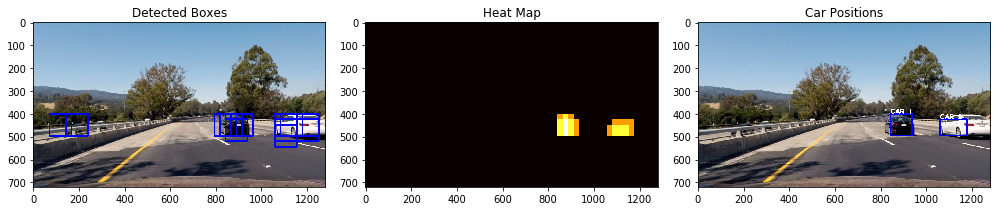

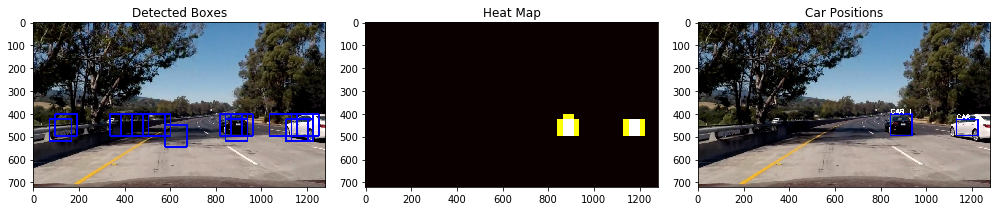

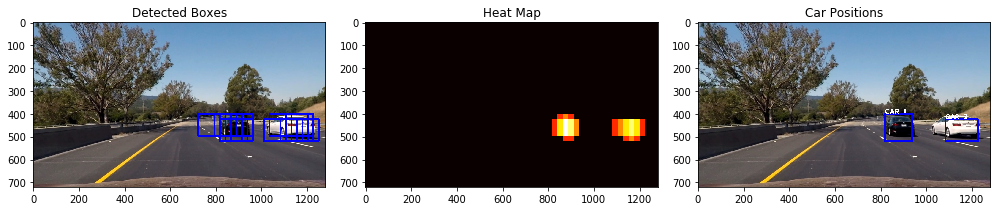

In [27]:
ystart = 400
ystop = 656
scale = 1.5
test_images = glob.glob('./test_images/*.jpg')
subplot_num = len(test_images)

for idx, file in enumerate(test_images):
    img = mpimg.imread(file)
    img = cv2.undistort(img, mtx, dist, None, mtx)
    
    draw_image = np.copy(img)

    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    # img = draw_image.astype(np.float32)/255

    out_img, bboxes = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block,
                                spatial_size,
                                hist_bins)

    # Make the heat map image and use it to create the final bounding boxes
    heat = np.zeros_like(img[:, :, 0]).astype(np.float)
    heat = add_heat(heat, bboxes)
    heat = apply_threshold(heat, 2)
    heatmap = np.clip(heat, 0, 255)
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(draw_image, labels)
    
    # Plot final bounding boxes and corresponding heat map image
    fig = plt.figure(figsize=(14, 24))
    fig.add_subplot(subplot_num, 3, 3 * idx + 1)
    plt.imshow(out_img)
    plt.title('Detected Boxes')
    fig.add_subplot(subplot_num, 3, 3 * idx + 2)
    plt.imshow(heatmap, cmap='hot')
    plt.title('Heat Map')
    fig.add_subplot(subplot_num, 3, 3 * idx + 3)
    plt.imshow(draw_img)
    plt.title('Car Positions')
    fig.tight_layout()

The following cell defines the function 'process_frame'. This function makes use of the python list name 'heatmaps' which stores the heatmaps for several previous frames to the current frame being evaluated in the video data being processed. The process image function will add all of the heat maps in the list together and then threshold the summed heat map to eliminate spurious detections that only ocassionaly appear with respect to time.

The process frame function also superimposes the lane detection from the CarND-Lane-Detection project.

In [12]:
# Now that our heat maps are shown to threshold well enough, we can integrate our heat maps for our final image processing function
heatmaps = []

def process_frame(frame_img):
    draw_img = np.copy(frame_img)
    draw_img = cv2.undistort(draw_img, mtx, dist, None, mtx)
    out_img, bboxes = find_cars(frame_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block,
                                spatial_size,
                                hist_bins)

    # Make the heat map image and use it to create the final bounding boxes
    heat = np.zeros_like(frame_img[:, :, 0]).astype(np.float)
    heat = add_heat(heat, bboxes)
    heat = apply_threshold(heat, 1)
    
    heatmaps.insert(0, heat)
    
    heat_integrated = np.zeros_like(img[:, :, 0]).astype(np.float)
    for heat_frame in heatmaps:
        heat_integrated = heat_integrated + heat_frame
    
    heat = apply_threshold(heat_integrated, 7)
    
    heatmap = np.clip(heat, 0, 255)
    labels = label(heatmap)
    
    if len(heatmaps) > 15:
        heatmaps.pop()
     
    # Add bounding boxes    
    vehicles_result = draw_labeled_bboxes(draw_img, labels)
        
    # Add lane detection output
    undist, warped, left_fit, right_fit, Minv, left_curverad, right_curverad, vehicle_offset_m, error = identify_lanes(draw_img)
    result = draw_lane(vehicles_result, warped, left_fit, right_fit, Minv, left_curverad, right_curverad, vehicle_offset_m,
                       error)
    
    return result

## Video processing

The following two cells use the process_frame function to overlay the vehicle and lane detections onto the test_video.mp4 and project_video.mp4 respectively

The videos can be viewed here:

[test_output](./output_images/test_output.mp4)

[project_output](./output_images/project_output.mp4)

In [28]:
heatmaps = []
lanes_history = []
video_output = "./output_images/test_output.mp4"
clip1 = VideoFileClip("./test_video.mp4")
clip1_output = clip1.fl_image(process_frame) #NOTE: this function expects color images!!
%time clip1_output.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video ./output_images/test_output.mp4
[MoviePy] Writing video ./output_images/test_output.mp4


 97%|█████████▋| 38/39 [00:19<00:00,  1.90it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_images/test_output.mp4 

CPU times: user 18.9 s, sys: 2.43 s, total: 21.4 s
Wall time: 19.8 s


In [29]:
heatmaps = []
video_output = "./output_images/project_output.mp4"
clip1 = VideoFileClip("./project_video.mp4")
clip1_output = clip1.fl_image(process_frame) #NOTE: this function expects color images!!
%time clip1_output.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video ./output_images/project_output.mp4
[MoviePy] Writing video ./output_images/project_output.mp4


100%|█████████▉| 1260/1261 [10:25<00:00,  2.01it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_images/project_output.mp4 

CPU times: user 10min 17s, sys: 1min 22s, total: 11min 40s
Wall time: 10min 25s


## Discussion

The pipeline seemed to work reliably enough but was still slow in processing speed and there were occasional false positives.

To speed the image processing up, we could use fewer elements in the feature vector. This would take much experimentation to get feature vectors minimized to the point that they are still reliable but I believe it can be done.

To help deal with false positives I could pour through the video and single out the windowed regions that were false positives and add them back into the noncar training data set several times over to make sure they are identified as non-car windows.

As with most machine learning approaches, having the algorithm encounter something it has never seen before will likely cause false positives are negatives. Something as odd as an art car or the oscar-meyer wiener mobile may prove to be undetectable by the SVC. A possible solution may be to incorporate other data such as in sensor fusion or searching for vehicle license plates may help with such cases.
